# Classification of Apoptotic cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

Reconstructing cell cycle and disease progression using deep learning. https://doi.org/10.1038/s41467-017-00623-3

We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

In [1]:
!pip -q install /pstore/home/shetabs1/code/MarrLab/scifAI/

You should consider upgrading via the '/pstore/apps/Python/3.8.3-2020.07/bin/python -m pip install --upgrade pip' command.


here we import a series of needed modules. 

In [2]:
import scifAI
import matplotlib.pyplot as plt
import scifAI.ml.features as features
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.ml.feature_extractor import FeatureExtractor
from scifAI.ml.segmentation import segment_all_channels
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [3]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred))
    print(classification_report_imbalanced(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

now lets calculate the metadata:

In [4]:
%%time

data_path = "/pstore/data/DS4/Cell_Cycle_h5/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 32266/32266 [00:02<00:00, 12079.66it/s]


Experiment_1 Donor_1 reco_cell.zip


0it [00:00, ?it/s]

...metadata prepration ended.
CPU times: user 1.1 s, sys: 500 ms, total: 1.6 s
Wall time: 3.2 s


<AxesSubplot:>

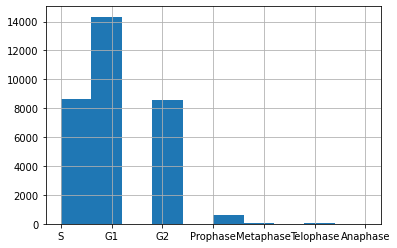

In [5]:
metadata.label.hist()

As you see, it is a very challenging classification task. For simplification, we downsample the majority classes

In [6]:
sample_size = 200
metadata_down_sampled = pd.DataFrame(columns=metadata.columns)


for cl in metadata.label.unique():
    row_index = metadata.label == cl
    metadata_down_sampled = metadata_down_sampled.append(metadata.loc[row_index, :].sample(min(sample_size, row_index.sum())),
                                                        ignore_index = True)
    

<AxesSubplot:>

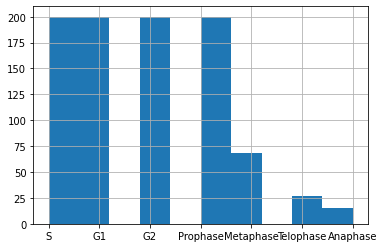

In [7]:
metadata_down_sampled.label.hist()

In [8]:

feature_union = FeatureUnion([
                                ("MaskBasedFeatures", features.MaskBasedFeatures()), 
                                ("GLCMFeatures", features.GLCMFeatures()),  
                                ("GradientRMS", features.GradientRMS()),  
                                ("BackgroundMean", features.BackgroundMean()), 
                                ("PercentileFeatures", features.PercentileFeatures()), 
                                ("CellShape", features.CellShape()),  
                                ("Collocalization", features.Collocalization()),    
                                ("IntersectionProperties", features.IntersectionProperties()),
                                ("CenterOfCellsDistances", features.CenterOfCellsDistances()),
                                ("HogFeatures", features.HogFeatures()),
]
)

because it is a very challenging task, we added Hog features

In [9]:
from scifAI.ml.segmentation import SegmentationGenerator

pipeline = Pipeline([
                     ("features", feature_union)], verbose=3)


In [10]:

feature_extractor = FeatureExtractor(pipeline)

before running the feature extraction, lets look at a random sample (the 0th entry in the metadata dataframe)

In [11]:
image, _ = feature_extractor.get_image_mask(metadata_down_sampled, 0)

In [12]:
image.shape

(66, 66, 3)

[]

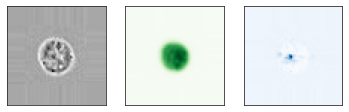

In [13]:
sns.set_style("white")
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 3, 
                       sharex = True, 
                       sharey = True)

ax[0].imshow(image[:,:,0], cmap = "Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(image[:,:,1], cmap = "Greens")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(image[:,:,2], cmap = "Blues")
ax[2].set_xticks([])
ax[2].set_yticks([])


In [14]:

list_of_features = feature_extractor.extract_features(metadata_down_sampled)

100%|██████████| 910/910 [00:04<00:00, 206.31it/s]


lets create a dataframe with the metadata

In [15]:
df_features = pd.DataFrame(list_of_features)

In [16]:
df_features.head()

,mask_based_area_Ch1,mask_based_bbox_area_Ch1,mask_based_convex_area_Ch1,mask_based_eccentricity_Ch1,mask_based_equivalent_diameter_Ch1,mask_based_euler_number_Ch1,mask_based_extent_Ch1,mask_based_feret_diameter_max_Ch1,mask_based_filled_area_Ch1,mask_based_major_axis_length_Ch1,...,Hog_190_Ch3,Hog_191_Ch3,Hog_192_Ch3,Hog_193_Ch3,Hog_194_Ch3,Hog_195_Ch3,Hog_196_Ch3,Hog_197_Ch3,Hog_198_Ch3,Hog_199_Ch3
0,511,702,537,0.277940,25.507360,1,0.727920,27.892651,511,26.180128,...,0.235538,0.345991,0.903343,0.229171,0.178695,0.078369,0.122626,0.259692,0.000000,0.104407
1,638,870,682,0.397034,28.501348,1,0.733333,31.016125,638,29.922523,...,0.396374,0.396374,0.589448,0.159714,0.104258,0.174708,0.589448,0.283816,0.133842,0.373814
2,620,837,656,0.604564,28.096415,1,0.740741,33.286634,620,31.631843,...,0.201112,0.259544,0.518092,0.030659,0.106262,0.515228,0.518092,0.319475,0.214885,0.192950
3,538,729,564,0.169765,26.172560,1,0.737997,27.892651,538,26.412809,...,0.317356,0.557993,0.450230,0.166544,0.241121,0.020778,0.450230,0.450230,0.320726,0.450230
4,621,812,643,0.141321,28.119064,1,0.764778,29.732137,621,28.267845,...,0.248164,0.439391,0.517605,0.091862,0.130461,0.353467,0.517605,0.193211,0.308721,0.425597


after creating the features, we impute empty values with 0. and delete features with no variance. After that, we name the features correctly based on their real name

In [17]:
df_features = df_features.fillna(0.)
df_features = df_features.loc[:, df_features.std() > 0.]

In [18]:
column_dict_rename = dict()

channel_names = {   
         "Ch1": "BF",
         "Ch2": "FL",
         "Ch2": "DF",}

for col in df_features.columns:
    new_col = col
    for ch in channel_names:
        new_col = new_col.replace(ch,channel_names[ch] )
    column_dict_rename[col] = new_col
    
df_features = df_features.rename(columns=column_dict_rename).copy()

let's create a train, validation and test set. We simply use the indexes, as it is easier to use it with sklearn pipelines

In [19]:
from scifAI.dl.utils import train_validation_test_split


train_index, validation_index, test_index = train_validation_test_split(metadata_down_sampled.index, 
                                                                        metadata_down_sampled.loc[:,"label"] + metadata_down_sampled.loc[:,"experiment"] + metadata_down_sampled.loc[:,"donor"],
                                                                        validation_size=0.20, 
                                                                        test_size=0.30)




lets train an XGBoost model on the data. we also use a feature selection before the classifiation to reduce the dimensionality

In [20]:
from sklearn import manifold, datasets
from sklearn import decomposition
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,RidgeCV,PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR

xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = 200 ,verbose=True)),
                 ('xgb', XGBClassifier(n_jobs = -1, n_estimators = 1000, eval_metric = "logloss") )
], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist(), :],  
       metadata_down_sampled.loc[train_index.tolist() + validation_index.tolist(), "label"] )

[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
Step 1: Find highly correlated features
Step 2: wrapper methods
Calculating mutual information
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic regression
Calculating xgb
number of similar features among all the methods: 0
From 843 initial features Selected (multicolinear): 185
Step 3: clustering over correlation of features
From 843 initial features Selected (uncorrelated): 50
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  12.5s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=   9.0s


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('AutoFeatureSelection',
                 AutoFeatureSelection(top_k=50, verbose=True)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
    

              precision    recall  f1-score   support

    Anaphase       0.83      1.00      0.91         5
          G1       0.77      0.77      0.77        60
          G2       0.54      0.43      0.48        60
   Metaphase       0.79      0.55      0.65        20
    Prophase       0.69      0.68      0.69        60
           S       0.52      0.67      0.58        60
   Telophase       0.89      1.00      0.94         8

    accuracy                           0.65       273
   macro avg       0.72      0.73      0.72       273
weighted avg       0.65      0.65      0.65       273

                   pre       rec       spe        f1       geo       iba       sup

   Anaphase       0.83      1.00      1.00      0.91      1.00      1.00         5
         G1       0.77      0.77      0.93      0.77      0.85      0.70        60
         G2       0.54      0.43      0.90      0.48      0.62      0.37        60
  Metaphase       0.79      0.55      0.99      0.65      0.74      0.

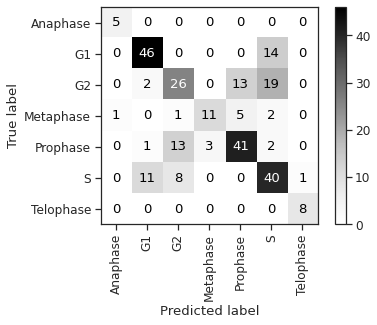

In [21]:
sns.set_style("white")
sns.set(font_scale = 1.1)

sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, :],
                               metadata_down_sampled.loc[test_index, "label"])

the classifier reached macro f1 of 0.72 which is comparable with the main publication. We can also look at the 50 preselected feautres using scifAI

In [22]:
selected_features = xgb.steps[1][1].selected_features
selected_feature_names = df_features.columns[selected_features]
selected_feature_names

Index(['mask_based_bbox_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_feret_diameter_max_BF', 'mask_based_minor_axis_length_BF',
       'mask_based_weighted_moments_hu-0_DF',
       'mask_based_weighted_moments_hu-1_DF', 'contrast_DF',
       'dissimilarity_DF', 'ASM_DF', 'contrast_Ch3', 'gradient_RMS_BF',
       'percentile_10_DF', 'kurtosis_intensity_BF', 'skew_intensity_BF',
       'sum_intensity_DF', 'correlation_distance_R1_BF_R2_DF',
       'euclidean_distance_R1_BF_R2_DF', 'structural_similarity_R1_BF_R2_DF',
       'structural_similarity_R1_BF_R3_Ch3', 'euclidean_distance_R2_DF_R3_Ch3',
       'Hog_10_BF', 'Hog_14_BF', 'Hog_35_BF', 'Hog_49_BF', 'Hog_51_BF',
       'Hog_52_BF', 'Hog_65_BF', 'Hog_84_BF', 'Hog_89_BF', 'Hog_104_BF',
       'Hog_109_BF', 'Hog_162_BF', 'Hog_196_BF', 'Hog_4_DF', 'Hog_13_DF',
       'Hog_19_DF', 'Hog_33_DF', 'Hog_46_DF', 'Hog_64_DF', 'Hog_93_DF',
       'Hog_106_DF', 'Hog_107_DF', 'Hog_129_DF', 'Hog_136_DF', 'Hog_150_DF',
       'Hog_152_D

Finally, the most important features based on the Gini-index and Permutation importance are:

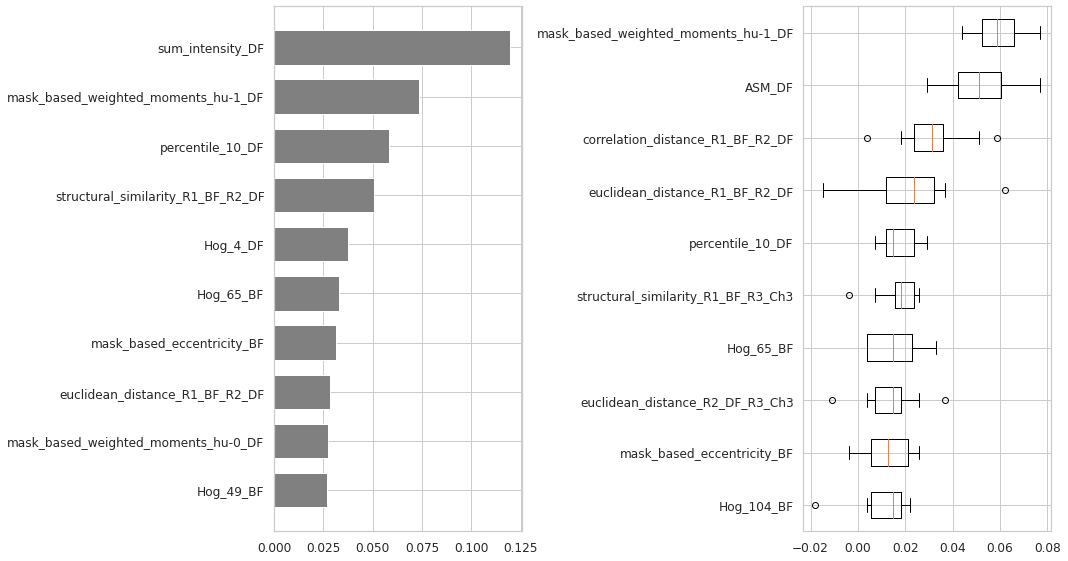

In [23]:
sns.set_style( "whitegrid" )

from sklearn.inspection import permutation_importance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(xgb.steps[2][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         xgb.steps[2][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(xgb, 
                                df_features.loc[test_index, :],
                                metadata_down_sampled.loc[test_index, "label"], 
                                n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns.values[perm_sorted_idx])

fig.tight_layout()